# Imports/setup

In [228]:
%matplotlib inline
import os
from pynq import Overlay
from pynq import allocate
import xrfclk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from axififo import AxiStreamFifoDriver
import scipy.signal
import scipy.io
import time
import serial
from datetime import datetime
from tqdm.notebook import tqdm

In [28]:
#ol = Overlay("hw/top_20240111_104744.bit", download=True) used to generate plots sent on slack on 1/11/24
#ol = Overlay("hw/top_20240112_123937.bit", download=True) partially working triangle waves, data_out.valid isn't enabled on any channel except channel 0
#ol = Overlay("hw/top_20240112_141513.bit", download=True)
#ol = Overlay("hw/top_20240112_152837.bit", download=True)
#ol = Overlay("hw/top_20240114_140538.bit", download=True)
#ol = Overlay("hw/top_20240114_195802.bit", download=True) # added disable for triggered-start of ADC buffer until buffer has been read out by DMA
#ol = Overlay("hw/top_20240114_225340.bit", download=True) # ILA, fixed disable? added output register to read the state of the ADC buffer
#ol = Overlay("hw/top_20240115_102015.bit", download=True) # can't get ILA to work
#ol = Overlay("hw/top_20240115_111719.bit", download=True) # actually works
ol = Overlay("hw/top_20240115_160553.bit", download=True) # added offset to dac_prescaler
xrfclk.set_ref_clks(lmk_freq=122.88, lmx_freq=409.6)

# DAQ API

In [230]:
dac_fsamp = 6.144e9 #Hz
dds_phase_bits = 32
tri_phase_bits = 32
scale_bits = 18
offset_bits = 14
scale_offset_int_bits = 2

verbose = False

adc_fsamp = 4.096e9 # Hz

awg_frame_depth_max = 2048 # don't change
awg_frame_depth = 2048 # multiply by 16 to get total samples
adc_buffer_data_depth = 2048
adc_buffer_tstamp_depth = 512
tstamp_width = 64

parallel_samples = 16
sample_width = 16
num_channels = 8

awg_dma = ol.axi_dma_0.sendchannel
adc_dma = ol.axi_dma_0.recvchannel
# 8x2048-deep data buffer (256b/word)
# 8x512-deep timestamp buffer (64b/word)
# information:
# 8x2x(64+256)
adc_dma_bits = num_channels*adc_buffer_data_depth*parallel_samples*sample_width # data buffer
adc_dma_bits += num_channels*adc_buffer_tstamp_depth*tstamp_width # timestamp buffer
adc_dma_bits += num_channels*2*(parallel_samples*sample_width+tstamp_width) # timestamp+data channel ID/ sample count info
adc_buffer = allocate(shape=(adc_dma_bits//64,), dtype=np.uint64)
# 8 x awg_frame_depth - deep data buffer (256b/word, 16 samples/word)
awg_buffer = allocate(shape=(num_channels*awg_frame_depth*parallel_samples,), dtype=np.uint16)

def clog2(x):
    return int(np.ceil(np.log2(x)))

def ns_to_samp(ns):
    return int(ns*1e-9*dac_fsamp)

def packetize(long_word, num_words):
    packet = []
    if verbose:
        print(f'packetizing word {long_word:#0{num_words*8}x} into {num_words} words')
    for word in range(num_words):
        packet.append(long_word & ((1 << 32) - 1))
        long_word >>= 32
    if long_word != 0:
        print(f'WARNING: packetize has leftover data {hex(long_word)}')
    return packet

def receive_adc_data(override_capture_done_error=False):
    if override_capture_done_error:
        adc_dma.transfer(adc_buffer)
        return
        
    num_pkts = ol.buffer_capture_done.fifo.read_num_rx_words()
    if num_pkts != 2:
        print(f"WARNING: didn't get the right number of packets on capture_done, should be exactly 2 (one for when capture_done went low, one for when it went high again)")
        return
    pkt_0 = ol.buffer_capture_done.fifo.get_rx_fifo_pkt()[0]
    if pkt_0 != 0:
        print(f'WARNING: first capture_done packet should be zero')
        print(f'try manually triggering the ADC buffer')
    else:
        pkt_1 = ol.buffer_capture_done.fifo.get_rx_fifo_pkt()[0]
        if pkt_1 != 1:
            print(f'WARNING: second capture_done packet should be one')
            print(f'try manually triggering the ADC buffer')
        else:
            if verbose:
                print(f'capture_done is asserted')
            adc_dma.transfer(adc_buffer)
    
def send_awg_data():
    awg_dma.transfer(awg_buffer)

def set_vga_atten_dB(atten_dB):
    for channel in range(num_channels):
        atten = round(atten_dB[channel])
        if atten < 0 or atten > 32:
            raise ValueError(f"atten_dB {atten} out of range, pick a number between 0 and 32dB")
        packet = 0x0200 | (atten & 0x3f) # address 0x02, 6-bit data atten_dB
        packet |= channel << 16 # address/channel ID is above 16-bit address+data
        if verbose:
            print(f'sending packet {packet} to lmh6401_config.fifo')
        ol.lmh6401_config.fifo.send_tx_pkt([packet])
    
def set_dac_scale_offset(scales, offsets):
    scale_offset_word = 0
    scale_frac_bits = scale_bits - scale_offset_int_bits
    offset_frac_bits = offset_bits - scale_offset_int_bits
    max_fs_val = 2**(scale_offset_int_bits - 1)
    
    for channel in range(num_channels):
        # scale is 2Q16, so quantize appropriately
        quant_scale = int(scales[channel] * 2**scale_frac_bits)
        quant_offset = int(offsets[channel] * 2**offset_frac_bits)
        if (scales[channel] >= max_fs_val  or scales[channel] < -max_fs_val):
            raise ValueError(f'cannot quantize {scales[channel]} to {scale_offset_int_bits}Q{scale_frac_bits}')
        if (offsets[channel] >= max_fs_val or offsets[channel] < -max_fs_val):
            raise ValueError(f'cannot quantize {offsets[channel]} to {scale_offset_int_bits}Q{offset_frac_bits}')
        if quant_scale < 0:
            quant_scale += 2**scale_bits
        if quant_offset < 0:
            quant_offset += 2**offset_bits
        scale_offset_word |= quant_scale << ((scale_bits + offset_bits) * channel + offset_bits)
        scale_offset_word |= quant_offset << ((scale_bits + offset_bits) * channel)
    if verbose:
        print(f'sending scale_word {hex(scale_offset_word)} to dac_scale_config.fifo')
    ol.dac_scale_offset_config.fifo.send_tx_pkt(packetize(scale_offset_word, ((scale_bits+offset_bits)*num_channels)//32))

def set_dds_freq(freqs_hz):
    pinc_word = 0
    for channel in range(num_channels):
        pinc = int((freqs_hz[channel]/dac_fsamp)*(2**dds_phase_bits))
        pinc_word |= pinc << (dds_phase_bits * channel)
    if verbose:
        print(f'sending pinc_word {hex(pinc_word)} to dds_phase_inc.fifo')
    ol.dds_phase_inc.fifo.send_tx_pkt(packetize(pinc_word, (dds_phase_bits * num_channels + 31) // 32))
    
def set_tri_freq(freqs_hz):
    pinc_word = 0
    for channel in range(num_channels):
        pinc = int((freqs_hz[channel]/dac_fsamp)*(2**tri_phase_bits))
        pinc_word |= pinc << (tri_phase_bits * channel)
    if verbose:
        print(f'sending pinc_word {hex(pinc_word)} to tri_phase_inc.fifo')
    ol.tri_phase_inc.fifo.send_tx_pkt(packetize(pinc_word, (tri_phase_bits * num_channels + 31) // 32))
    
def set_awg_triggers(trigger_modes):
    trigger_word = 0
    for channel in range(num_channels):
        if trigger_modes[channel] not in range(0,3):
            raise ValueError(f'invalid selection for trigger mode ({trigger_modes[channel]}) on channel ({channel})')
        trigger_word |= trigger_modes[channel] << (2*channel)
    if verbose:
        print(f'sending trigger_word {hex(trigger_word)} to awg_trigger_out_config.fifo')
    ol.awg_trigger_out_config.fifo.send_tx_pkt([trigger_word])
    
def set_awg_burst_length(burst_lengths):
    packet = []
    for channel in range(num_channels):
        packet.append(burst_lengths[channel] & ((1 << 32) - 1))
        packet.append((burst_lengths[channel] >> 32) & ((1 << 32) - 1))
    if verbose:
        print(f'sending packet {packet} to awg_burst_length.fifo')
    ol.awg_burst_length.fifo.send_tx_pkt(packet)
    
def set_awg_frame_depth(depths):
    frame_depth_word = 0
    for channel in range(num_channels):
        if depths[channel] not in range(0, awg_frame_depth + 1):
            raise ValueError(f'invalid frame depth ({depths[channel]}) for channel ({channel})')
        frame_depth_word |= depths[channel] << (clog2(awg_frame_depth_max+1)*channel)
    if verbose:
        print(f'sending frame_depth word = {hex(frame_depth_word)} to awg_frame_depth.fifo')
    ol.awg_frame_depth.fifo.send_tx_pkt(packetize(frame_depth_word, (clog2(awg_frame_depth_max+1)*num_channels + 31)//32))

def start_awg():
    ol.awg_start_stop.fifo.send_tx_pkt([2])
    
def stop_awg():
    ol.awg_start_stop.fifo.send_tx_pkt([1])

def start_adc_buffer():
    ol.buffer_start_stop.fifo.send_tx_pkt([0x2])
    
def stop_adc_buffer():
    ol.buffer_start_stop.fifo.send_tx_pkt([0x1])

def sink_select_all_adcs():
    ol.adc_mux_config.fifo.send_tx_pkt([0x76543210])

def source_select(sources):
    mux_word = 0
    for channel in range(num_channels):
        if sources[channel] not in range(3*num_channels):
            raise ValueError(f'invalid signal source index ({sources[channel]}), pick one between 0 and {3*num_channels}')
        mux_word |= sources[channel] << (clog2(3*num_channels)*channel)
    if verbose:
        print(f'sending dac mux_word {hex(mux_word)} to dac_mux_config.fifo')
    ol.dac_mux_config.fifo.send_tx_pkt(packetize(mux_word, (clog2(3*num_channels)*num_channels + 31)//32)) # packetize into 2x 32b quantities
    
def source_select_all_dds():
    source_select(list(range(num_channels,2*num_channels)))
    
def source_select_all_awg():
    source_select(list(range(num_channels)))
    
def source_select_all_tri():
    source_select(list(range(2*num_channels,3*num_channels)))

def set_buffer_num_active_channels(num_active_channels):
    # todo accomodate more than 8 channels
    if num_active_channels not in [1,2,4,8]:
        raise ValueError(f'Incorrect number of active channels: {num_active_channels}, expected one of [1,2,4,8]')
    banking_mode = clog2(num_active_channels)
    if verbose:
        print(f'sending banking mode packet {banking_mode} to buffer_config.fifo')
    ol.buffer_config.fifo.send_tx_pkt([banking_mode])

def set_sample_discriminator_config(low_thresholds, high_thresholds):
    packet = []
    for channel in range(8):
        low = low_thresholds[channel]
        high = high_thresholds[channel]
        if low not in range(0,2**sample_width):
            raise ValueError(f'invalid low_threshold ({hex(low)}) for channel {channel}, should be between 0x00 and 0xff')
        if high not in range(0,2**sample_width):
            raise ValueError(f'invalid high_thresholds ({hex(high)}) for channel {channel}, should be between 0x00 and 0xff')
        packet.append((high << sample_width) | low)
    if verbose:
        print(f'sending sample_discriminator packet {packet} to sample_discriminator_config.fifo')
    ol.sample_discriminator_config.fifo.send_tx_pkt(packet)

def set_trigger_manager_config(combine_mode, mask):
    if mask not in range(0, 2**(2*num_channels)):
        raise ValueError(f'Incorrect mask value {hex(mask)}, should be an {2*num_channels}-bit quantity')
    if combine_mode.lower() not in ['and', 'or']:
        raise ValueError(f'Incorrect combine mode {combine_mode}, should be and/or (case insensitive)')
    comb_bit = 1 if combine_mode.lower() == 'and' else 0
    word = (comb_bit << (2*num_channels)) | mask
    if verbose:
        print(f'sending word {hex(word)} to trigger_manager_config.fifo')
    ol.trigger_manager_config.fifo.send_tx_pkt([word])
    
def parse_adc_data(adc_buffer, num_active_channels, adc_buffer_tstamp_depth, adc_buffer_data_depth, parallel_samples):
    if num_active_channels not in [1,2,4,8]:
        raise ValueError(f'Incorrect number of active channels: {num_active_channels}, expected one of [1,2,4,8]')
    dma_word = 0
    dma_word_leftover_bits = 0
    dma_buffer_index = 0
    word_width = 64 # until we get the axis-register to work, don't use get_tstamp_width()
    word_mask = (1 << word_width) - 1
    parse_mode = "timestamp"
    need_channel_id = True
    need_word_count = True
    parsed_bank_count = 0
    done_parsing = False
    words_remaining = None
    # TODO generalize for banking mode other than 0x2
    timestamps = np.zeros((num_active_channels, (8//num_active_channels)*adc_buffer_tstamp_depth),dtype=np.uint64)
    samples = np.zeros((num_active_channels, (8//num_active_channels)*adc_buffer_data_depth*parallel_samples),dtype=np.int16)
    timestamp_index = [0 for i in range(num_active_channels)]
    sample_index = [0 for i in range(num_active_channels)]
    while not done_parsing:
        for _ in range(2 if parse_mode == "timestamp" else 4):
            dma_word = (int(adc_buffer[dma_buffer_index]) << dma_word_leftover_bits) | dma_word
            dma_word_leftover_bits += 64 # 64b numpy array
            dma_buffer_index += 1
        while dma_word_leftover_bits >= word_width:
            if need_channel_id:
                current_channel = dma_word & word_mask
                need_channel_id = False
                need_word_count = True
            else:
                if need_word_count:
                    words_remaining = dma_word & word_mask
                    need_word_count = False
                else:
                    if parse_mode == "timestamp":
                        timestamps[current_channel][timestamp_index[current_channel]] = dma_word & word_mask
                        timestamp_index[current_channel] += 1
                    elif parse_mode == "data":
                        for i in range(parallel_samples):
                            samples[current_channel][sample_index[current_channel]] = (dma_word >> (16*i)) & 0xffff
                            sample_index[current_channel] += 1
                    words_remaining -= 1
                if words_remaining == 0:
                    need_channel_id = True
                    parsed_bank_count += 1
            if parsed_bank_count == num_channels:
                if parse_mode == "timestamp":
                    word_width = parallel_samples*16
                    parse_mode = "data"
                else:
                    done_parsing = True
                dma_word = 0
                dma_word_leftover_bits = 0
                parsed_bank_count = 0
            else:
                dma_word >>= word_width
                dma_word_leftover_bits -= word_width
    return timestamps, samples, timestamp_index, sample_index

# time parser

In [232]:
%timeit parse_adc_data(adc_buffer, num_active_channels, adc_buffer_tstamp_depth, adc_buffer_data_depth, parallel_samples)

428 µs ± 929 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Test API

In [30]:
def generate_pulse(pulse_param_ns):
    period_samples = ns_to_samp(pulse_param_ns[4])
    delay_samples = ns_to_samp(pulse_param_ns[3])
    rise_samples = ns_to_samp(pulse_param_ns[0])
    fall_samples = ns_to_samp(pulse_param_ns[2])
    width_samples = ns_to_samp(pulse_param_ns[1])
    data = np.zeros(period_samples)
    offset = delay_samples
    # rising edge
    data[offset:offset+rise_samples] = np.linspace(0, 2**15 - 1, rise_samples)
    offset += rise_samples
    # mesa
    data[offset:offset+width_samples] = 2**15 - 1
    offset += width_samples
    # falling edge
    data[offset:offset+fall_samples] = np.linspace(2**15 - 1, 0, fall_samples)
    return data

def get_savefile(device_name):
    return datetime.now().strftime("%Y%m%d_%H%M%S") + f'_{device_name}'

In [31]:
def loopback_test(num_active_channels, adc_atten_dB):
    device_name = 'loopback'
    active_channels = num_active_channels
    ##########################################
    # setup AWG
    ##########################################
    print(f'setting up AWG')
    stop_awg() # stop the AWG to make sure we return to DMA_IDLE state
    set_awg_triggers([1] + [0]*7) # set the trigger to output a 1 only at the beginning of a burst, only on channel 0
    num_bursts = 8
    set_awg_burst_length([num_bursts]*8) # if burst_length = 0, run for 2^64 - 1 cycles, basically forever

    ### generate waveform to send ###
    # set dac scale and set mux to use AWG
    pulse_param_ns = [1, 1, 1, 0, 50]
    num_pulses = 100
    #####  SET OUTPUT AMPLITUDES ####
    bias = np.zeros(8)
    ampl = dac_scale_per_mV * gate_ampl_mV
    set_dac_scale_offset(ampl, bias + dac_bias_correction)
    # set mux to select AWGs
    source_select_all_awg()
    # generate waveform
    for i in range(num_channels):
        pulse_period_samples = ns_to_samp(pulse_param_ns[4])
        start = i*awg_frame_depth*parallel_samples
        end = (i+1)*awg_frame_depth*parallel_samples
        # clear buffer
        awg_buffer[start:end] = 0
        for j in range(num_pulses):
            awg_buffer[start:start+pulse_period_samples] = generate_pulse(pulse_param_ns)
            start += pulse_period_samples
    ##########################################
    # setup ADC buffer
    ##########################################
    print(f'setting up ADC buffer')
    # set trigger manager configuration:
    set_trigger_manager_config('or', 0x1) # OR all channel triggers after applying mask 0x1
    sink_select_all_adcs()
    #####  SET VGA GAIN/ATTENUATION ####
    set_vga_atten_dB(adc_atten_dB)
    set_sample_discriminator_config([2**15]*8, [2**15]*8) # save everything
    set_buffer_num_active_channels(active_channels)
    ##########################################
    # set frame depth and do DMA
    ##########################################
    print(f'starting AWG')
    # DMA buffer is allocated at num_channels x awg_frame_depth x 256b, so set frame length of awg_frame_depth
    set_awg_frame_depth([awg_frame_depth]*num_channels)
    send_awg_data()
    start_awg()
    print(f'DMA transfer exit code = {ol.awg_dma_error.fifo.get_rx_fifo_pkt()}')
    ##########################################
    # receive data
    ##########################################
    time.sleep(0.01)
    print(f'receiving ADC data')
    receive_adc_data(False)
    return get_savefile(device_name)

def plot_loopback_test(adc_buffer, savefile, num_active_channels, filter_param, t_min_us, t_max_us):
    timestamps, samples, num_timestamps, num_samples = parse_adc_data(adc_buffer, num_active_channels, adc_buffer_tstamp_depth, adc_buffer_data_depth, parallel_samples)
    if verbose:
        print(f'got {num_timestamps} timestamps')
    f, ax = plt.subplots(num_active_channels,1,sharex=True,figsize=(12,8),dpi=90)
    tvec = np.linspace(0,(8//num_active_channels)*adc_buffer_data_depth*parallel_samples/adc_fsamp,(8//num_active_channels)*adc_buffer_data_depth*parallel_samples,endpoint=False)
    sos = scipy.signal.butter(filter_param[0], filter_param[1], btype=filter_param[2], output='sos', fs=adc_fsamp)
    zi = scipy.signal.sosfilt_zi(sos)
    for channel in range(num_active_channels):
        ax[channel].plot(tvec*1e6, samples[channel]/2**sample_width, '.', alpha=0.05, label='raw data')
        if filter_param is not None:
            x0 = np.mean(samples[channel][0:int(50e-9*dac_fsamp)])
            filt, _ = scipy.signal.sosfilt(sos, samples[channel]/2**sample_width, zi=zi*x0/2**sample_width)
            ax[channel].plot(tvec*1e6, filt, '.', alpha=0.1, label=f"{filter_param[0]}-th order {'-'.join(str(round(f)/1e6) for f in filter_param[1])}MHz {filter_param[2]}")
    ax[0].set_xlim(t_min_us, t_max_us)
    ax[num_active_channels-1].set_xlabel('t [us]')
    ax[num_active_channels-1].legend()
    if savefile is not None:
        f.savefig(f'figures/{savefile}.png', facecolor='white', transparent=False)

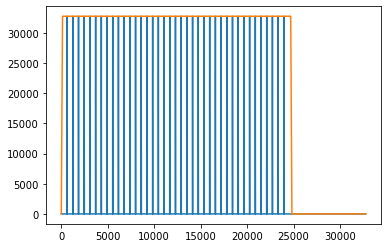

In [32]:
def generate_ntron_pulse(gate_pulse_param_ns, channel_pulse_param_ns):
    # do pulses on channel to fill entire duration
    # pulses on gate: wait for channel to rise, i.e. (channel init_delay) + (gate period), wait for channel to fall
    # e.g. for 4us-long channel pulse, do 38x 100ns-periodic gate pulses
    data = np.zeros(shape=(num_channels*awg_frame_depth*parallel_samples,), dtype=np.uint16)
    channel_period = ns_to_samp(channel_pulse_param_ns[4])
    channel_delay = ns_to_samp(channel_pulse_param_ns[3])
    gate_period = ns_to_samp(gate_pulse_param_ns[4])
    buffer_length = awg_frame_depth*parallel_samples
    num_channel_pulses = (buffer_length // channel_period)
    num_gate_pulses = (ns_to_samp(channel_pulse_param_ns[1]) // gate_period) - 1
    gate_start_sample = channel_period*np.arange(0, num_channel_pulses) + channel_delay + gate_period
    gate_stop_sample = gate_start_sample + num_gate_pulses * gate_period
    for i in range(num_channels):
        start = i*awg_frame_depth*parallel_samples
        end = (i+1)*awg_frame_depth*parallel_samples
        # clear buffer
        awg_buffer[start:end] = 0
        for j in range(num_channel_pulses):
            if i == 0:
                # gate
                offset = start
                for k in range(num_gate_pulses):
                    data[offset+gate_start_sample[j]:offset+gate_start_sample[j]+gate_period] = generate_pulse(gate_pulse_param_ns)
                    offset += gate_period
                start += channel_period
            elif i == 1:
                # channel
                data[start:start+channel_period] = generate_pulse(channel_pulse_param_ns)
                start += channel_period
            else:
                break
    return data
# test
awg_data = generate_ntron_pulse([1,1,1,0,100], [20,4000,20,0,5000])
plt.plot(awg_data[0:awg_frame_depth*parallel_samples])
plt.plot(awg_data[awg_frame_depth*parallel_samples:2*awg_frame_depth*parallel_samples])

In [33]:
def single_ntron_pulse_test(device, gate_mV, channel_mV, gate_pulse_param_ns, channel_pulse_param_ns, adc_atten_dB):
    # pulse_param_ns
    # rise, hold, fall, init_delay, period
    device_name = f'pulse_{device}'
    active_channels = 2
    ##########################################
    # setup AWG
    ##########################################
    stop_awg() # stop the AWG to make sure we return to DMA_IDLE state
    set_awg_triggers([0]*8) # disable trigger generation
    set_awg_burst_length([0]*8) # send data continuously
    stop_awg() # stop the AWG to make sure we return to DMA_IDLE state
    #####  SET OUTPUT AMPLITUDES ####
    ampl_mV = np.array([gate_mV, channel_mV] + [0]*6)
    bias = np.zeros(8)
    ampl = dac_scale_per_mV * ampl_mV
    set_dac_scale_offset(ampl, bias + dac_bias_correction)
    # set mux to select AWGs
    source_select_all_awg()
    # generate waveform for gate and channel
    awg_buffer[0:awg_buffer.size] = generate_ntron_pulse(gate_pulse_param_ns, channel_pulse_param_ns)
    ##########################################
    # setup ADC buffer
    ##########################################
    # set trigger manager configuration:
    set_trigger_manager_config('or', 0x0) # disable triggers
    sink_select_all_adcs()
    #####  SET VGA GAIN/ATTENUATION ####
    set_vga_atten_dB(adc_atten_dB)
    set_sample_discriminator_config([2**15]*8, [2**15]*8) # save everything
    set_buffer_num_active_channels(active_channels)
    ##########################################
    # set frame depth and do DMA
    ##########################################
    # DMA buffer is allocated at num_channels x awg_frame_depth x 256b, so set frame length of awg_frame_depth
    set_awg_frame_depth([awg_frame_depth]*num_channels)
    send_awg_data()
    start_awg()
    time.sleep(0.001)
    start_adc_buffer()
    time.sleep(0.001)
    stop_adc_buffer()
    # set trigger manager configuration:
    exit_code = ol.awg_dma_error.fifo.get_rx_fifo_pkt()
    if (len(exit_code) != 1) or (exit_code[0] > 0):
        print(f'DMA transfer exit code = {exit_code}')
    ##########################################
    # receive data
    ##########################################
    receive_adc_data(False)
    stop_awg() # stop the AWG to disable output
    return get_savefile(device_name)

In [34]:
def sweep_single_ntron_pulse_test(device, vg_sweep, vch_sweep, tperiod_sweep, thold_sweep, tslew_sweep, adc_atten_dB):
    device_name = f'sweep_pulse_{device}'
    savefile = get_savefile(device_name)
    adc_data = np.zeros((adc_buffer.size, len(vg_sweep), len(vch_sweep), len(tperiod_sweep), len(thold_sweep), len(tslew_sweep)), dtype=np.uint16)
    gate_pulse_params = np.zeros((5, len(vg_sweep), len(vch_sweep), len(tperiod_sweep), len(thold_sweep), len(tslew_sweep)))
    channel_pulse_params = np.array([20,4000,20,0,5000])
    progress_bar = tqdm(total=len(vg_sweep)*len(vch_sweep)*len(tperiod_sweep)*len(thold_sweep)*len(tslew_sweep), smoothing=0.05)
    # sweep Ig
    for (vg_i, vg) in enumerate(vg_sweep):
        # sweep Ich
        for (vch_i, vch) in enumerate(vch_sweep):
            # sweep timing
            for (tperiod_i, tperiod) in enumerate(tperiod_sweep):
                for (thold_i, thold) in enumerate(thold_sweep):
                    thold = (max(ns_to_samp(thold),1)/dac_fsamp)*1e9
                    if thold > tperiod/2:
                        progress_bar.update(len(tslew_sweep))
                        continue
                    for (tslew_i, tslew) in enumerate(tslew_sweep):
                        if thold + 2*tslew > tperiod:
                            progress_bar.update(1)
                            continue
                        gate_params_i = np.array([tslew, thold, tslew, 0, tperiod])
                        _ = single_ntron_pulse_test(device, vg, vch, gate_params_i, channel_pulse_params, adc_atten_dB)
                        # save data
                        # adc_buffer
                        adc_data[:,vg_i,vch_i,tperiod_i,thold_i,tslew_i] = adc_buffer[:]
                        # gate_pulse_param_ns
                        gate_pulse_params[:,vg_i,vch_i,tperiod_i,thold_i,tslew_i] = gate_params_i
                        progress_bar.update(1)
    progress_bar.close()
    print("saving data to file")
    np.savez(f'data/{savefile}',
        adc_data=adc_data,
        num_active_channels=2,
        gate_pulse_param_ns=gate_pulse_params,
        channel_pulse_param_ns=channel_pulse_params,
        adc_atten_dB=adc_atten_dB,
    )
    return savefile

In [194]:
np.tile(np.array([1,2,3]), 3)

array([1, 2, 3, 1, 2, 3, 1, 2, 3])

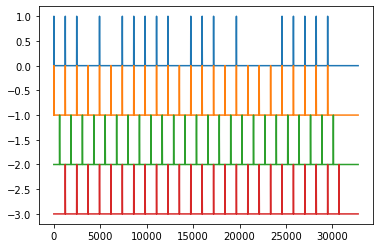

In [202]:
def generate_shiftreg_pulses(pulse_param_ns):
    # do random pulses on DAC0, clock pulses on DAC1, DAC2, DAC3 (DAC1, DAC3 same phase as DAC0, DAC2 180deg out of phase)
    data = np.zeros(shape=(num_channels*awg_frame_depth*parallel_samples,), dtype=np.uint16)
    clock_period = ns_to_samp(pulse_param_ns[4])
    # subtract 1 so that we always clear out everything we send
    num_pulses = (awg_frame_depth*parallel_samples)//clock_period
    # ignore pulse_param_ns[3] delay and substitute 0 and pulse_param_ns[4]/2 (period / 2)
    phi1_param_ns = pulse_param_ns.copy()
    phi2_param_ns = pulse_param_ns.copy()
    phi1_param_ns[3] = 0
    phi2_param_ns[3] = pulse_param_ns[4]/2
    phi1_pulse = generate_pulse(phi1_param_ns)
    phi2_pulse = generate_pulse(phi2_param_ns)
    chan_size = awg_frame_depth*parallel_samples
    data[0:num_pulses*clock_period] = np.kron(np.random.randint(2, size=(num_pulses,)), phi1_pulse)
    for i in range(1,num_channels):
        start = i*awg_frame_depth*parallel_samples
        end = start+num_pulses*clock_period
        if i > 3:
            break
        data[start:end] = np.tile(phi1_pulse if i != 2 else phi2_pulse, num_pulses)
        if i < 3:
            data[end-clock_period:end] = 0
        else:
            data[start:start+clock_period] = 0
    return data
# test
pulse_param_ns = np.array([1,1,1,0,200])
awg_data = generate_shiftreg_pulses(pulse_param_ns)
for channel in range(4):
    plt.plot(awg_data[channel*awg_frame_depth*parallel_samples:(channel+1)*awg_frame_depth*parallel_samples]/2**15 - channel)

In [187]:
def single_shiftreg_measurement(expt_name, pulse_param_ns, input_mV, clk1_mV, clk2_mV, clkro_mV, adc_atten_dB):
    device_name = f'SPG717_single_{expt_name}'
    savefile = get_savefile(device_name)
    num_active_channels = 4
    ##########################################
    # setup AWG
    ##########################################
    stop_awg() # stop the AWG to make sure we return to DMA_IDLE state
    set_awg_triggers([1] + [0]*7) # set the trigger to output a 1 only at the beginning of a burst, only on channel 0
    num_bursts = 8
    set_awg_burst_length([num_bursts]*8) # if burst_length = 0, run for 2^64 - 1 cycles, basically forever
    stop_awg() # stop the AWG to make sure we return to DMA_IDLE state
    #####  SET OUTPUT AMPLITUDES ####
    ampl_mV = np.array([input_mV, clk1_mV, clk2_mV, clkro_mV] + [0]*4)
    bias = np.zeros(8)
    ampl = dac_scale_per_mV * ampl_mV
    set_dac_scale_offset(ampl, bias + dac_bias_correction)
    # set mux to select AWGs
    source_select_all_awg()
    # generate waveform for gate and channel
    start = time.time()
    awg_buffer[0:awg_buffer.size] = generate_shiftreg_pulses(pulse_param_ns)
    stop = time.time()
    print(f'generate shiftreg pulse runtime = {stop - start} s')
    ##########################################
    # setup ADC buffer
    ##########################################
    # set trigger manager configuration:
    set_trigger_manager_config('or', 0x1) # trigger from the first DAC channel (DAC0)
    sink_select_all_adcs()
    #####  SET VGA GAIN/ATTENUATION ####
    set_vga_atten_dB(adc_atten_dB)
    set_sample_discriminator_config([2**15]*8, [2**15]*8) # save everything
    set_buffer_num_active_channels(num_active_channels)
    ##########################################
    # set frame depth and do DMA
    ##########################################
    # DMA buffer is allocated at num_channels x awg_frame_depth x 256b, so set frame length of awg_frame_depth
    set_awg_frame_depth([awg_frame_depth]*num_channels)
    send_awg_data()
    start_awg()
    time.sleep(0.001)
    # set trigger manager configuration:
    exit_code = ol.awg_dma_error.fifo.get_rx_fifo_pkt()
    if (len(exit_code) != 1) or (exit_code[0] > 0):
        print(f'DMA transfer exit code = {exit_code}')
    time.sleep(0.001)
    receive_adc_data(False)
    print("saving data to file")
    np.savez(f'data/{savefile}',
        adc_data=adc_buffer,
        dac_data=awg_buffer,
        num_active_channels=num_active_channels,
        pulse_param_ns=pulse_param_ns,
        input_mV=input_mV,
        clk1_mV=clk1_mV,
        clk2_mV=clk2_mV,
        clkro_mV=clkro_mV,
        adc_atten_dB=adc_atten_dB,
    )
    return savefile

In [167]:
def plot_shiftreg_experiment(savefile, trange):
    f = np.load(f'data/{savefile}.npz')
    num_active_channels = f['num_active_channels']
    timestamps, samples, num_timestamps, num_samples = parse_adc_data(f['adc_data'], num_active_channels, adc_buffer_tstamp_depth, adc_buffer_data_depth, parallel_samples)
    if verbose:
        print(f'got {num_timestamps} timestamps')
    fig, ax = plt.subplots(2,1,sharex=True,figsize=(12,8),dpi=90)
    tvec_awg = np.linspace(0,awg_frame_depth*parallel_samples/dac_fsamp,awg_frame_depth*parallel_samples,endpoint=False)
    dac_data = f['dac_data']
    dac_labels = ["input", "clk1", "clk2", "clkro"]
    for channel in range(4):
        data = 0.8 * dac_data[channel*awg_frame_depth*parallel_samples:(channel+1)*awg_frame_depth*parallel_samples]/2**15 - channel
        ax[0].plot(160e-3 + tvec_awg*1e6, data, label=dac_labels[channel])
    ax[0].legend()
    tvec = np.linspace(0,(8//num_active_channels)*adc_buffer_data_depth*parallel_samples/adc_fsamp,(8//num_active_channels)*adc_buffer_data_depth*parallel_samples,endpoint=False)
    adc_labels = ["shunt1", "shunt2", "output"]
    yoffset = 0
    prev_min = 0
    for channel in range(3):
        data = samples[channel]/2**sample_width
        yoffset += np.max(data - yoffset) - prev_min
        data -= 1.1*yoffset
        prev_min = np.min(data)
        ax[1].plot(tvec*1e6, data, '.', alpha=0.2, label=adc_labels[channel])
    ax[1].legend(loc='lower right')
    ax[0].set_xlim(trange[0], trange[1])
    ax[1].set_xlabel('t [us]')
    fig.suptitle(f'{savefile}\ninput, clk1, clk2, clkro amplitudes (uA) = {np.array([input_mV, clk1_mV, clk2_mV, clkro_mV])/1e3/50*1e6}')
    plt.tight_layout()
    plt.savefig(f'figures/{savefile}.png')

# Calibration

In [9]:
# calibration of dac scale/offset
# get output voltage on 50-ohm load with inputs of -0.25,0,0.25 (quarter of full scale range - doing full scale range introduces nonlinearity which messes up calibration)
# ideally would get a calibration curve to do digital pre-distortion, but that would take too long to manually calibrate, and the analog board doesn't have the necessary components to do an autocal

# step 1:
# set quarter of minimum for all outputs, measure voltage
set_dac_scale_offset([0]*8, [(2**15+2**14+2**13)/2**16]*8)

In [10]:
dac_min_voltage_mV = np.array([-20.2, -13.9, -20.9, -16.2, -15.1, -15.1, -19.4, -13.1])

In [11]:
# step 2:
# set zero for all outputs, measure voltage
set_dac_scale_offset([0]*8, [0]*8)

In [12]:
dac_zero_voltage_mV = np.array([-2.4, 2.8, -3.0, 1.0, 1.2, 2.3, -1.1, 3.1])

In [13]:
set_dac_scale_offset([0]*8, [(2**13 - 1)/2**16]*8)

In [14]:
dac_max_voltage_mV = np.array([15.5, 18.4, 14.2, 17.7, 17.3, 19.1, 17.6, 19.8])

In [15]:
dac_scale_per_mV = (0.25 - -0.25)/(dac_max_voltage_mV - dac_min_voltage_mV)
dac_bias_correction = -dac_scale_per_mV*(dac_max_voltage_mV + 2*dac_zero_voltage_mV + dac_min_voltage_mV)/8#-dac_zero_voltage_mV*dac_scale_per_mV

In [16]:
set_dac_scale_offset([0]*8, dac_bias_correction)

# Shiftreg experiments

In [226]:
expt_name = 'bringup'
pulse_param_ns = np.array([0.75, 0.5, 0.75, 0, 5])
input_mV = 140e-6*50*1e3
clk1_mV = 220e-6*50*1e3
clk2_mV = 250e-6*50*1e3
clkro_mV = 60e-6*50*1e3
adc_atten_dB = [20, 20, 20] + [32]*5
start = time.time()
savefile = single_shiftreg_measurement(expt_name, pulse_param_ns, input_mV, clk1_mV, clk2_mV, clkro_mV, adc_atten_dB)
stop = time.time()
print(f'runtime = {stop - start} s')

generate shiftreg pulse runtime = 0.008761405944824219 s
saving data to file
runtime = 0.03656339645385742 s


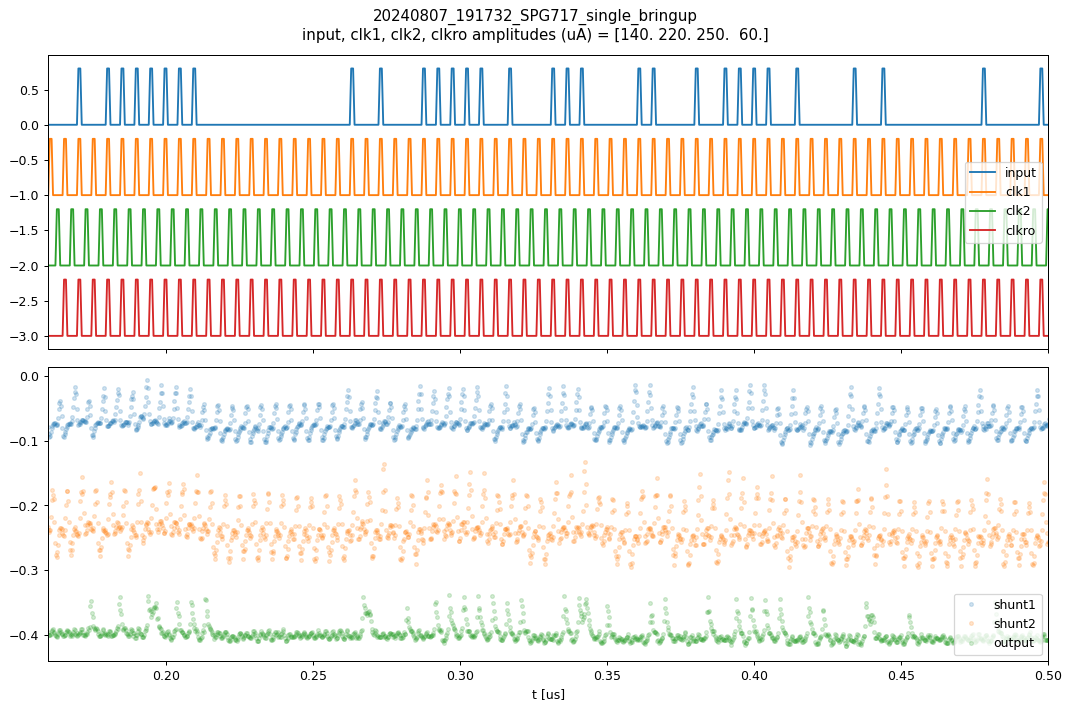

In [227]:
plot_shiftreg_experiment(savefile, [0.16, 0.5])

# nTron experiments - sweep

In [17]:
device = 'A1'
#vg_sweep = np.concatenate((np.linspace(0,6,20), np.linspace(7,10,4)))
vg_sweep = np.linspace(0,12,20)
vch_sweep = np.linspace(45,55,10)
tperiod_sweep = np.array([30, 100, 500])
thold_sweep = np.array([0, 2, 50, 200])
tslew_sweep = np.array([0, 1, 5])
adc_atten_dB = [9, 9] + [32]*6
start = time.time()
savefile = sweep_single_ntron_pulse_test(device, vg_sweep, vch_sweep, tperiod_sweep, thold_sweep, tslew_sweep, adc_atten_dB)
stop = time.time()
print(f'runtime = {stop - start} s')

  0%|          | 0/7200 [00:00<?, ?it/s]

saving data to file
runtime = 263.74312567710876 s


In [18]:
savefile

'20240723_093932_sweep_pulse_A1'

In [19]:
f = np.load('data/20240723_093932_sweep_pulse_A1.npz')

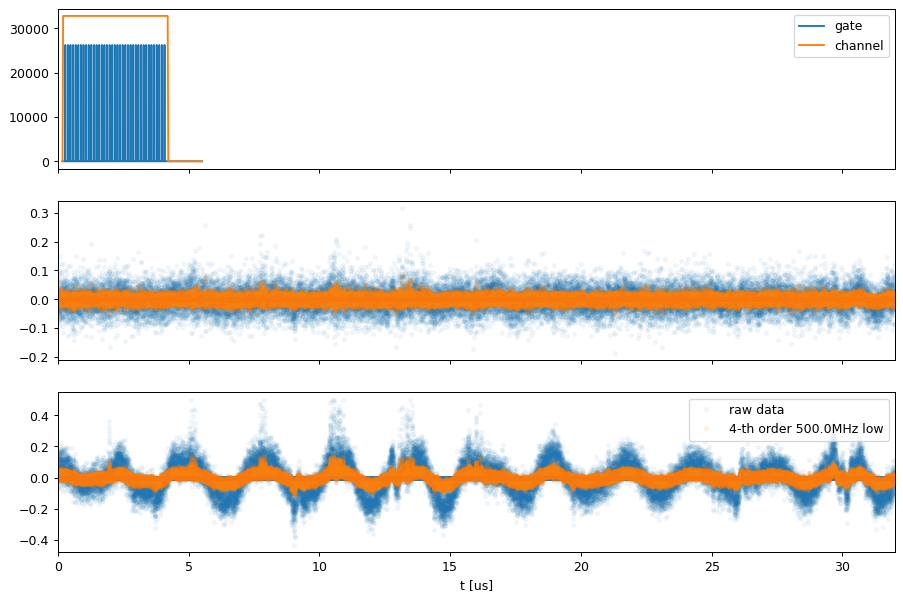

In [26]:
vg_i = 9
vch_i = 4
tperiod_i = 1
thold_i = 1
tslew_i = 1
num_active_channels = 2
filter_param = (4, (500e6,), 'low')
timestamps, samples, num_timestamps, num_samples = parse_adc_data(f['adc_data'][:,vg_i,vch_i,tperiod_i,thold_i,tslew_i], num_active_channels, adc_buffer_tstamp_depth, adc_buffer_data_depth, parallel_samples)
if verbose:
    print(f'got {num_timestamps} timestamps')
fig, ax = plt.subplots(1+num_active_channels,1,sharex=True,figsize=(12,8),dpi=90)
tvec_awg = np.linspace(0,awg_frame_depth*parallel_samples/dac_fsamp,awg_frame_depth*parallel_samples,endpoint=False)
awg_data = generate_ntron_pulse(f['gate_pulse_param_ns'][:,vg_i,vch_i,tperiod_i,thold_i,tslew_i], f['channel_pulse_param_ns'])
ax[0].plot(182e-3 + tvec_awg*1e6, 0.8*awg_data[0:awg_frame_depth*parallel_samples], label='gate')
ax[0].plot(182e-3 + tvec_awg*1e6, awg_data[awg_frame_depth*parallel_samples:2*awg_frame_depth*parallel_samples], label='channel')
ax[0].legend()
tvec = np.linspace(0,(8//num_active_channels)*adc_buffer_data_depth*parallel_samples/adc_fsamp,(8//num_active_channels)*adc_buffer_data_depth*parallel_samples,endpoint=False)
sos = scipy.signal.butter(filter_param[0], filter_param[1], btype=filter_param[2], output='sos', fs=adc_fsamp)
zi = scipy.signal.sosfilt_zi(sos)
for channel in range(num_active_channels):
    ax[1+channel].plot(tvec*1e6, samples[channel]/2**sample_width, '.', alpha=0.05, label='raw data')
    if filter_param is not None:
        x0 = np.mean(samples[channel][0:int(50e-9*dac_fsamp)])
        filt, _ = scipy.signal.sosfilt(sos, samples[channel]/2**sample_width, zi=zi*x0/2**sample_width)
        ax[1+channel].plot(tvec*1e6, filt, '.', alpha=0.1, label=f"{filter_param[0]}-th order {'-'.join(str(round(f)/1e6) for f in filter_param[1])}MHz {filter_param[2]}")
ax[0].set_xlim(0, 32)
ax[num_active_channels].set_xlabel('t [us]')
ax[num_active_channels].legend()

# nTron experiments - single bias

In [560]:
338e3*24*125/1e9

1.014

In [549]:
np.linspace(0,5,20)
np.linspace(6,10,5)

array([ 6.,  7.,  8.,  9., 10.])

In [80]:
device = 'A1'
gate_mV = 12
channel_mV = 52
gate_pulse_param_ns = [0,20,0,0,100]
channel_pulse_param_ns = [20,4000,20,0,5000]
adc_atten_dB = [12, 12] + [32]*6
start = time.time()
savefile = single_ntron_pulse_test(device, gate_mV, channel_mV, gate_pulse_param_ns, channel_pulse_param_ns, adc_atten_dB)
stop = time.time()
print(f'runtime = {stop - start} s')

runtime = 0.02587127685546875 s


runtime = 0.029453039169311523 s


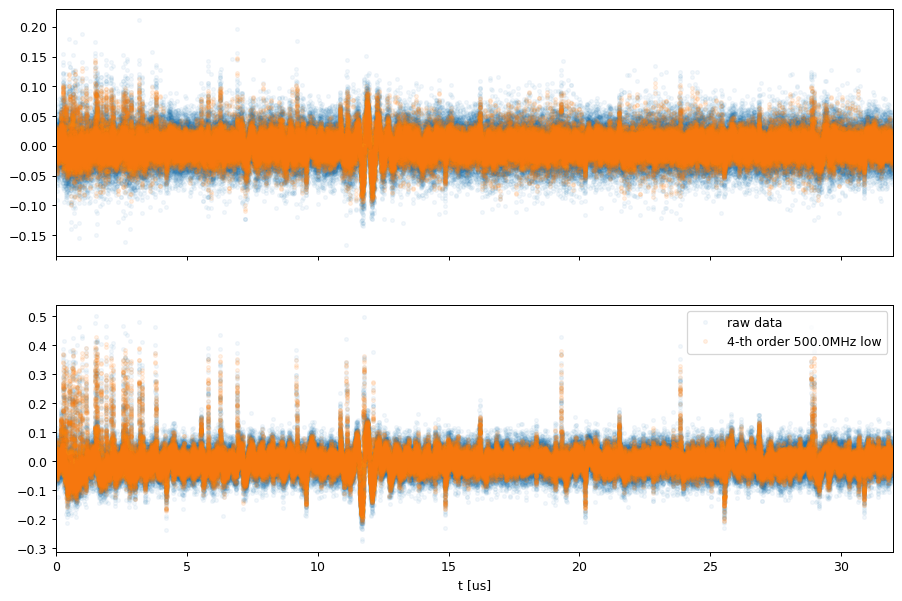

In [42]:
device = 'A1'
gate_mV = 4
channel_mV = 52
gate_pulse_param_ns = [1,2,1,0,100]
channel_pulse_param_ns = [20,4000,20,0,5000]
adc_atten_dB = [12, 12] + [32]*6
start = time.time()
savefile = single_ntron_pulse_test(device, gate_mV, channel_mV, gate_pulse_param_ns, channel_pulse_param_ns, adc_atten_dB)
stop = time.time()
print(f'runtime = {stop - start} s')
plot_loopback_test(adc_buffer, savefile, 2, (4, (500e6,), 'low'), 0, 32)
np.savez_compressed(f'data/{savefile}',
    dma_data=adc_buffer,
    awg_data=awg_buffer,
    num_active_channels=2,
    gate_mV=gate_mV,
    channel_mV=channel_mV,
    gate_pulse_param_ns=gate_pulse_param_ns,
    channel_pulse_param_ns=channel_pulse_param_ns,
    adc_atten_dB=adc_atten_dB,
)

In [564]:
savefile

'20240722_181249_single_grayzone_A1'

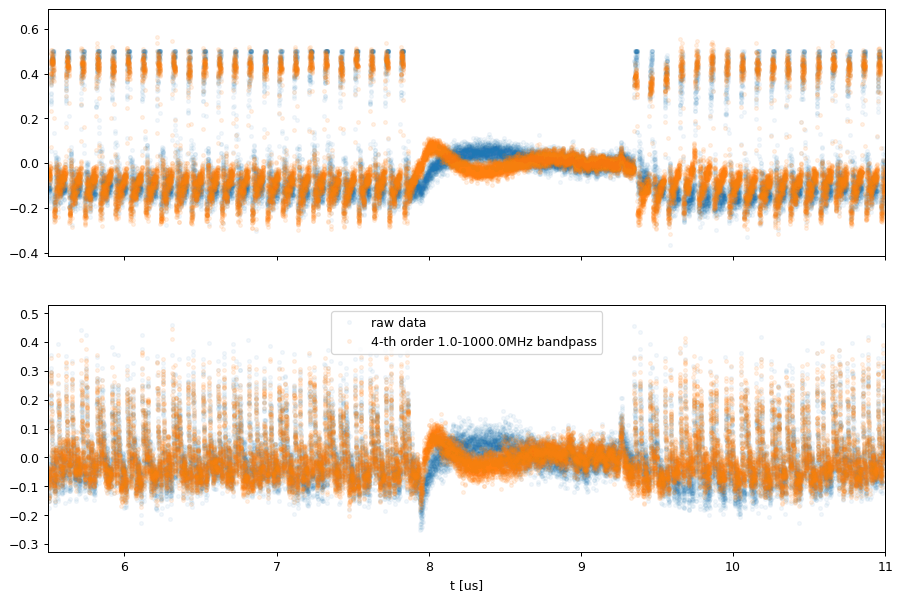

In [81]:
plot_loopback_test(adc_buffer, None, 2, (4, (1e6, 1e9,), 'bandpass'), 5.5, 11)

## Test we can load from the savefile

In [ ]:
f = np.load('data/20240722_181249_single_grayzone_A1.npz')

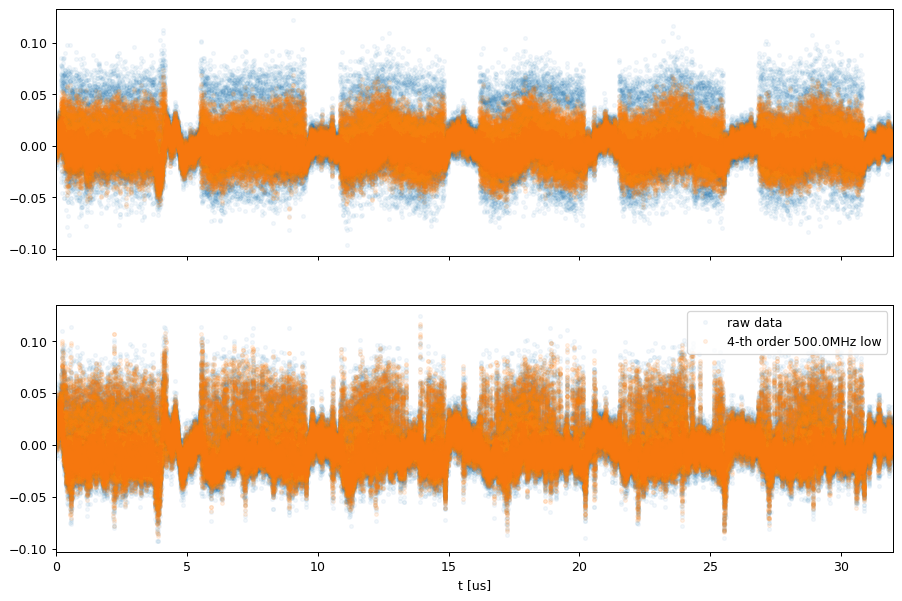

In [571]:
num_active_channels = 2
filter_param = (4, (500e6,), 'low')
timestamps, samples, num_timestamps, num_samples = parse_adc_data(f['dma_data'], num_active_channels)
if verbose:
    print(f'got {num_timestamps} timestamps')
fig, ax = plt.subplots(num_active_channels,1,sharex=True,figsize=(12,8),dpi=90)
tvec = np.linspace(0,(8//num_active_channels)*adc_buffer_data_depth*parallel_samples/adc_fsamp,(8//num_active_channels)*adc_buffer_data_depth*parallel_samples,endpoint=False)
sos = scipy.signal.butter(filter_param[0], filter_param[1], btype=filter_param[2], output='sos', fs=adc_fsamp)
zi = scipy.signal.sosfilt_zi(sos)
for channel in range(num_active_channels):
    ax[channel].plot(tvec*1e6, samples[channel]/2**sample_width, '.', alpha=0.05, label='raw data')
    if filter_param is not None:
        x0 = np.mean(samples[channel][0:int(50e-9*dac_fsamp)])
        filt, _ = scipy.signal.sosfilt(sos, samples[channel]/2**sample_width, zi=zi*x0/2**sample_width)
        ax[channel].plot(tvec*1e6, filt, '.', alpha=0.1, label=f"{filter_param[0]}-th order {'-'.join(str(round(f)/1e6) for f in filter_param[1])}MHz {filter_param[2]}")
ax[0].set_xlim(0, 32)
ax[num_active_channels-1].set_xlabel('t [us]')
ax[num_active_channels-1].legend()

# Postprocessing/Analysis

## Jitter

In [427]:
def filt_data(data, filter_cfg, adc_fsamp):
    sos = scipy.signal.butter(filter_cfg[0],filter_cfg[1],btype=filter_cfg[2],output='sos',fs=adc_fsamp)
    zi = scipy.signal.sosfilt_zi(sos)
    x0 = np.mean(data[0:int(50e-9*adc_fsamp)])
    filt, _ = scipy.signal.sosfilt(sos, data/2**sample_width, zi=zi*x0/2**sample_width)
    return filt

def get_peaks(data, filter_cfg, adc_fsamp, pulse_period_ns):
    filt = filt_data(data, filter_cfg, adc_fsamp)
    peaks, _ = scipy.signal.find_peaks(filt, height=0.3*np.max(filt), prominence=0.7*np.max(filt), distance=0.5*pulse_period_ns*1e-9*adc_fsamp)
    return peaks

def get_peak_delays(data, filter_cfg, pulse_period_ns, pulses_per_burst, num_bursts, upsample=10):
    pulse_period = int(pulse_period_ns*1e-9*dac_fsamp)/dac_fsamp
    frame_period = awg_frame_depth*parallel_samples/dac_fsamp
    burst_times = np.linspace(0, pulses_per_burst*pulse_period, pulses_per_burst, endpoint=False)
    # delay to first pulse is 180ns
    init_delay = 195e-9
    expected_delays = init_delay + np.linspace(burst_times, frame_period*num_bursts + burst_times, num_bursts, endpoint=False).reshape(num_bursts * pulses_per_burst, 1)

    burst_length_adc_samples = int(awg_frame_depth*parallel_samples/dac_fsamp*adc_fsamp)
    adc_tvec = np.linspace(0, len(data)/adc_fsamp, len(data), endpoint=False)
    adc_up_tvec = np.linspace(0, (len(data)*upsample-1)/(adc_fsamp*upsample), len(data)*upsample-1, endpoint=False)
    # get rough location of peaks
    peaks = get_peaks(data, filter_cfg, adc_fsamp, pulse_period_ns)
    # find rising edge location
    upsamp = scipy.signal.resample_poly(filt_data(data/2**sample_width, filter_cfg, adc_fsamp), upsample, 1)
    diff = np.diff(upsamp)
    rel_times = np.zeros(expected_delays.shape)
    delta_n = int(pulse_period_ns*1e-9/2*adc_fsamp*upsample)
    for p, t_exp in enumerate(expected_delays):
        n = int(t_exp*adc_fsamp*upsample)
        t_rec = (np.argmax(diff[n-delta_n:n+delta_n])+n-delta_n)/(adc_fsamp*upsample)
        rel_times[p] = t_exp - t_rec
    return rel_times

(-1e-09, -5e-10)

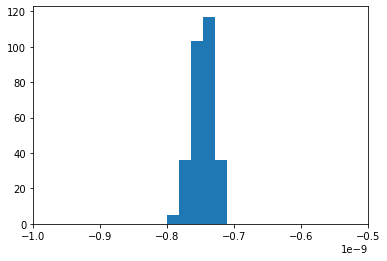

In [434]:
timestamps, samples, num_timestamps, num_samples = parse_adc_data(adc_buffer, 4, adc_buffer_tstamp_depth, adc_buffer_data_depth, parallel_samples)
delays = get_peak_delays(samples[0], (4, (1e6, 500e6), 'bandpass'), 50, 100, 3)
#_ = plt.hist(delays, bins=1000)
#plt.xlim(-1e-9, -5e-10)